# 使用 def 构架模型

回顾之前的例子，我们都是一层一层手动堆叠，最终得到一个模型，如：  

```python
    input_layer = Input(...)
    
    conv_1 = Conv2D(...)(input_layer)
    maxpool_1 = Maxpooling2D()(conv_1)
    
    conv_2 = Conv2D(...)(conv_1)
    maxpool_2 = Maxpooling2D()(conv_2)
    ...
    conv_n = Conv2D(...)(conv_n-1)
    maxpool_n = Maxpooling2D()(conv_n)
```

这样做虽然能清晰知道各层的名字和上一层传递进来的内容，但显然十分冗余，而且有很多重复的内容。  

先前咱们搭建的网络层数都在10层左右，用这种方式还能说的过去，但即便是最简单的 VGG16 都至少有 21 层，更别提诡异的 InceptionResNet 572 层了。  
如果真的就这样一层一层搭建下来，不考虑会不会出错，首先键盘都能被你抹掉一层皮。  

下面将介绍如何使用 def 来简化这种操作，那么显然这次的作业就是将前面模型中重复的部分用 def 的方式进行改写。  

----------------------

* 不要觉得我看懂了就行，咱们都出生于普通高校，没有清北学生的悟性就得多动手。【无他惟手熟尔】

实际上我的学生中有 985 院校的同学，他们身上令我最敬佩的品质便是不会嫌弃我普通高校的出身，而且很肯吃苦，让他们把案例敲 5 遍没有丝毫怨言和质疑为什么做这些重复工作。  

代码的学习一开始都是从模仿开始，通过大量的仿写至少让人在语法关上保持通畅，充分了解函数调用及参数填空，仿写的多了自然会开始领悟其中的逻辑，随后再进行创作。就像艺术创作一样，刚开始照着鸡蛋画画，等炉火纯青的时候仰望星空绘出传世佳作。

In [1]:
from tensorflow import keras
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.datasets import mnist
from tensorflow.keras.preprocessing import sequence

import numpy as np
import matplotlib.pyplot as plt

-----------------

# 一：简单的栈式结构

定义连续的 Conv2D 和 MaxPooling2D 操作。  

In [2]:
def conv_maxpool(x, filters):
    flowData = x
    for fl in filters:
        flowData = Conv2D(fl, 3, padding='same', activation='relu')(flowData)
        flowData = MaxPooling2D()(flowData)
    return flowData

定义连续的 Dense 操作

In [3]:
def dense_block(x, unitsList):
    flowData = x
    for uni in unitsList:
        flowData = Dense(uni, activation='relu')(flowData)
    return flowData

搭建模型

In [4]:
input_layer = Input(shape=(28, 28, 1))

conv_block = conv_maxpool(input_layer, [32, 64, 32])
flatten = Flatten()(conv_block)
dense_block = dense_block(flatten, [16, 10, 10])

In [5]:
model = Model(inputs=input_layer, outputs=dense_block)

可以看见，在搭建模型的时候只使用了 4 行代码就得到了一个深度为 11 的网络。  

这个例子可能体会不是很深，但已经能窥见其便捷性。

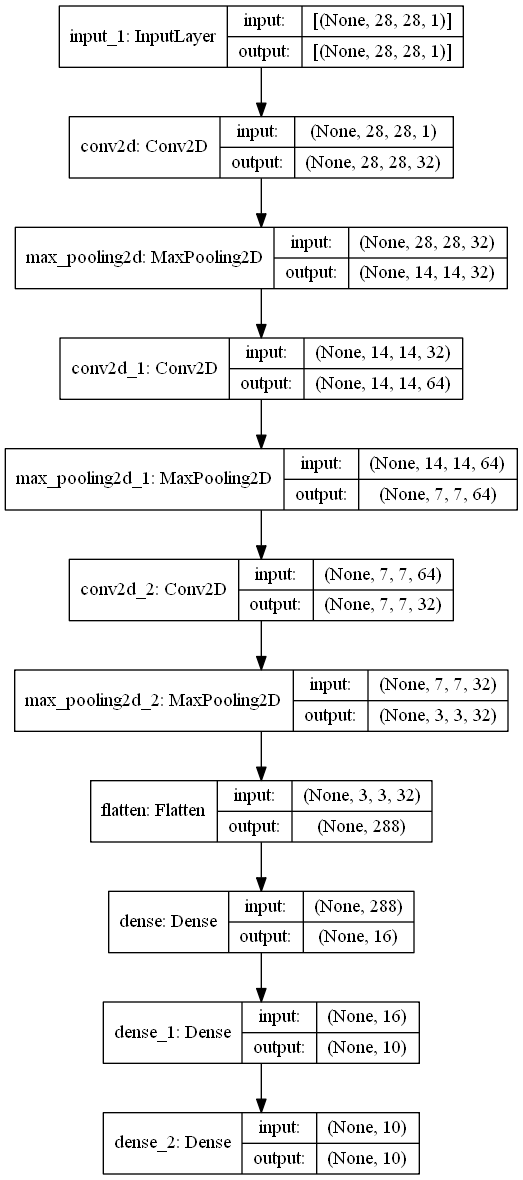

In [6]:
plot_model(model, show_shapes=True)

---------------------

# 二：含有短接的 Res 结构

短接的概念在图像处理中十分重要，可以说是一个突破性创新，他让超深的神经网络成为可能。

第一次提到短接概念是 ResNet 模型，所以一般会在函数名中加上 ‘res’ 以表示这里存在短接操作。

这里涉及到 ‘梯度消失’ 的概念，在 Quick Start 中不进行详述，感兴趣的可以在知乎上搜索关键字，但我的建议是当前阶段不必太过深入，以锻炼快速搭建模型能力为主

In [7]:
def res_conv_maxpool(x, filters):
    shortCut = x        # 用于短接的变量
    flowData = x        # 用于流程的变量
    for fl in filters:
        flowData = Conv2D(fl, 3, activation='relu', padding='same')(flowData)
    flowData = Add()([shortCut, flowData])       # 短接
    flowData = MaxPooling2D()(flowData)
    return flowData

In [8]:
input_layer = Input(shape=(100, 100, 1))

res_block = res_conv_maxpool(input_layer, [32, 64, 128])   
res_block = res_conv_maxpool(res_block, [30, 60, 128])    # 注意，当前函数最后的 128 需要一致，后续将会介绍不一致的写法
flatten = Flatten()(res_block)
dense_layer = Dense(10, activation='relu')(flatten)

In [9]:
model = Model(inputs=input_layer, outputs=dense_layer)

这个时候就能体现出使用 def 的优势了，仅需一句话就能让模型增加 5 层的深度

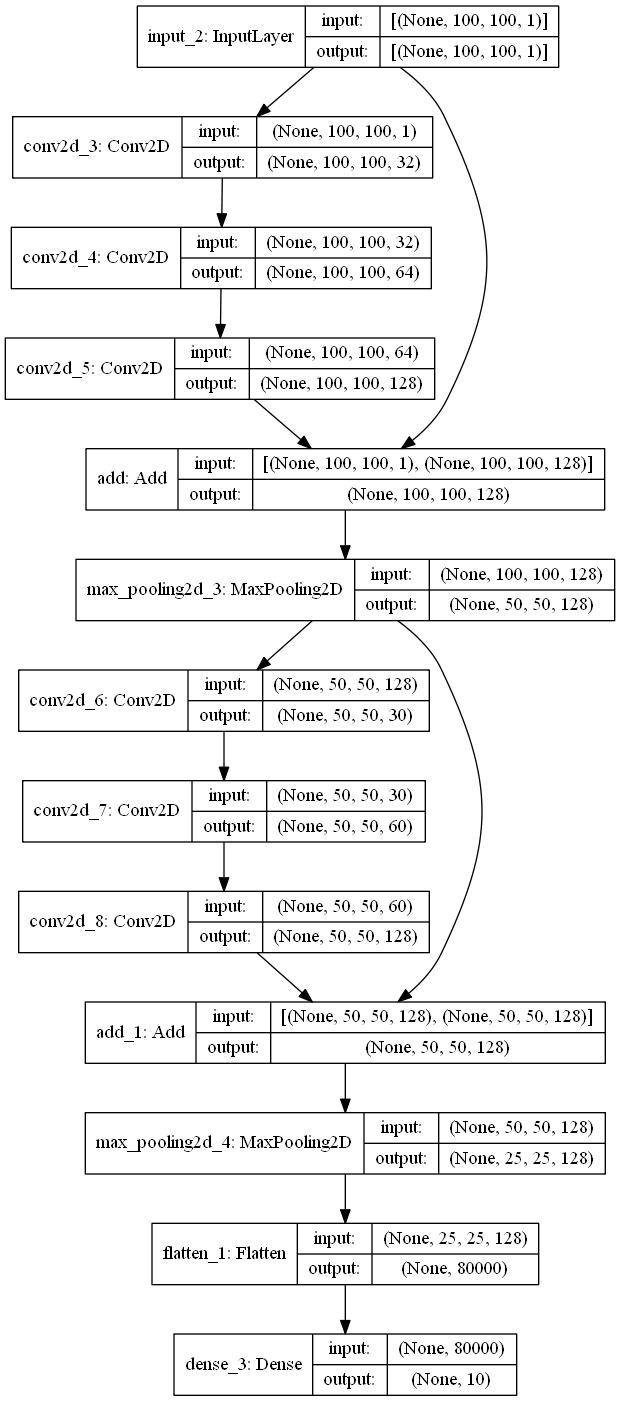

In [10]:
plot_model(model, show_shapes=True)

----------------------

# 三：含有短接的 Dense 结构

前面提到了短接操作能够使图像处理网络性能提升，那么本着 ‘力大砖飞’ 的思想，如果给每一层都进行短接是不是效果会更好呢？  

确实，有人这么做了，这就是 DenseNet 网络。  

 

In [11]:
def res_block(x, filter_num_list, kernel_size_list):
    filter1, filter2, filter3 = filter_num_list
    kersiz1, kersiz2, kersiz3 = kernel_size_list
    # 连续的三层卷积
    conv_1 = Conv2D(filters=filter1, kernel_size=kersiz1)(x)
    conv_2 = Conv2D(filters=filter2, kernel_size=kersiz2, padding='same')(conv_1)
    conv_3 = Conv2D(filters=filter3, kernel_size=kersiz3, padding='same')(conv_2)
    # 一层短接层
    short_cut = Conv2D(filters=filter3, kernel_size=kersiz3)(x)
    # 一层融合层
    add_layer = Add()([short_cut, conv_3])
    # 一层池化层
    maxpool = MaxPooling2D()(add_layer)
    return maxpool

In [12]:
input_layer = Input(shape=(224, 224, 3))

# 两个Dense模块
dense_1 = res_block(input_layer, [32, 64, 128], [3, 3, 3])
dense_2 = res_block(dense_1, [128, 128, 256], [3,3,3])

# 一路短接
short_cut = Conv2D(filters=256, kernel_size=9, strides=4)(input_layer)
add_layer = Add()([dense_2, short_cut])

maxpool = MaxPooling2D()(add_layer)

In [13]:
model = Model(inputs=input_layer, outputs=maxpool)

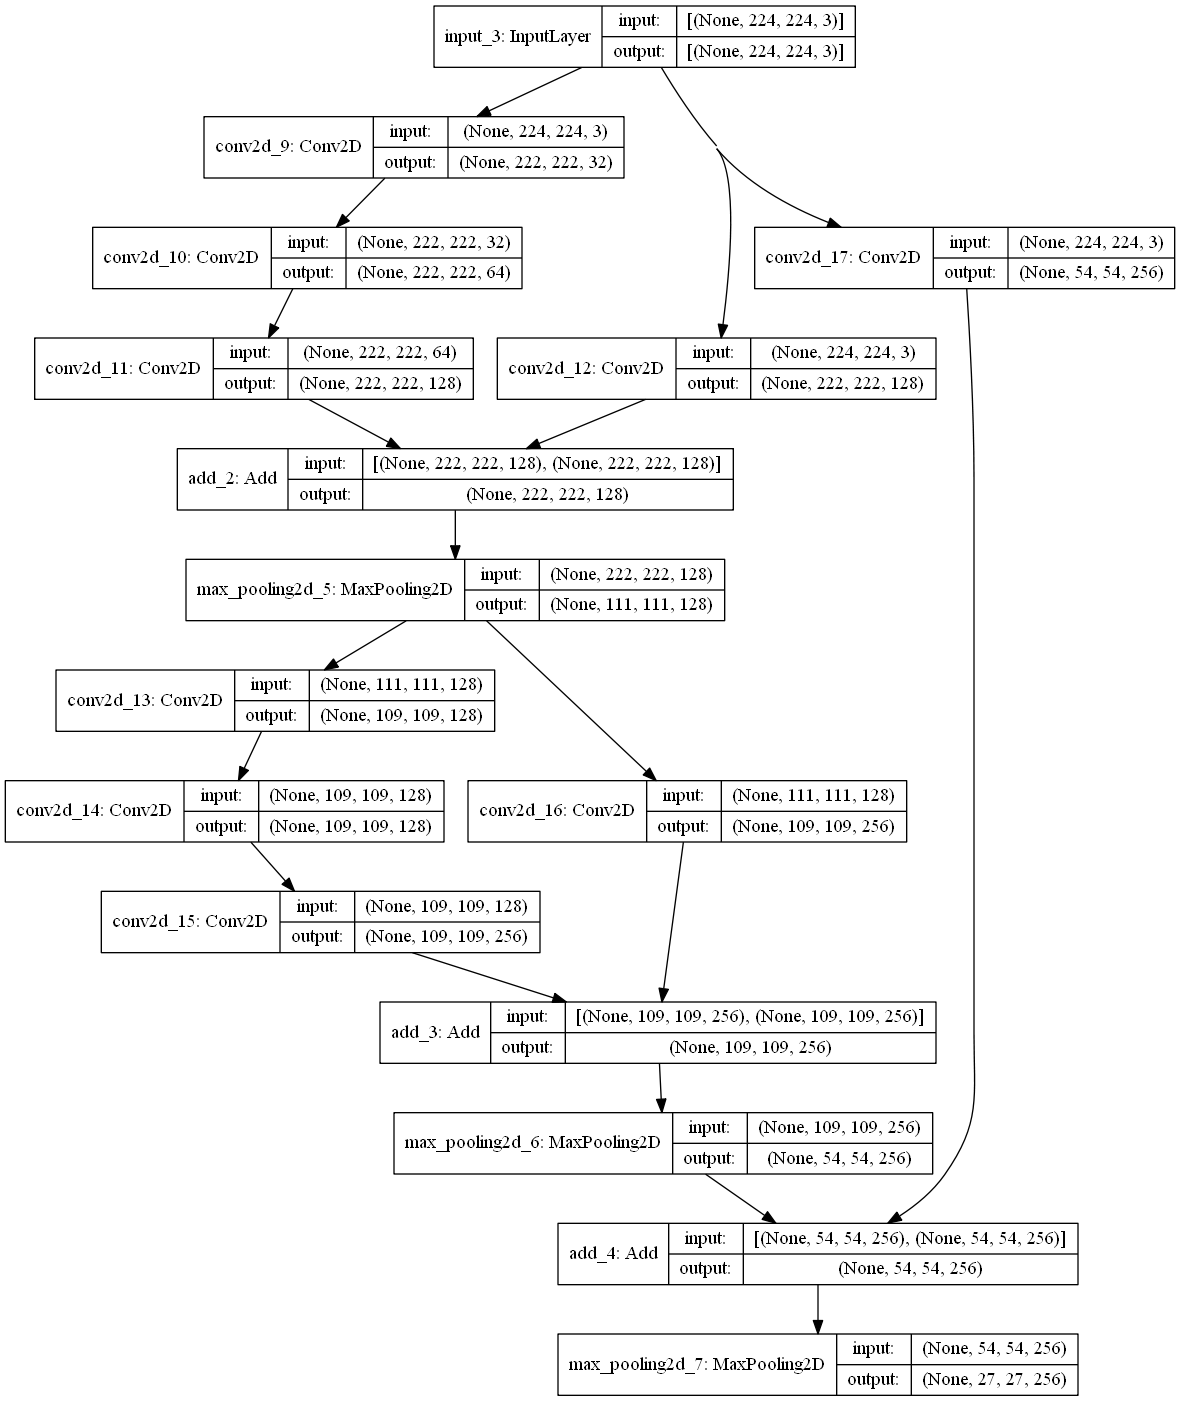

In [14]:
plot_model(model, show_shapes=True)